# **Giro Dictionary**

In [1]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# DB 연결
# !pip install pymysql
import pymysql

# 실시간 주식가격 데이터
# !pip install finance-datareader
import FinanceDataReader as fdr

# 텍스트 분석
from konlpy.tag import Okt

# 기타
import datetime
from collections import Counter

## **Read Data**

### **① 기존 감성 어휘 사전**

In [2]:
# 블로그에서 가져온 기본적인 한국어 긍부정 텍스트 목록
with open('negative_words_self.txt', encoding='utf-8') as neg:
    negative = neg.readlines()
negative = [neg.replace('\n', '') for neg in negative]

with open('positive_words_self.txt', encoding='utf-8') as pos:
    positive = pos.readlines()
positive = [pos.replace('\n', '') for pos in positive]

### **② News Data from DB**

**삼성전자 뉴스 데이터**

In [3]:
db = pymysql.connect(user='root',
                     passwd='1234',
                     host='3.35.70.166',
                     db='proj',
                     charset='utf8')

cursor = db.cursor(pymysql.cursors.DictCursor)

# 삼성전자 뉴스 데이터
sql = "select * from news_craw_005930 where length(date)=10"
cursor.execute(sql)

result = cursor.fetchall()

# DataFrame으로 변경
df = pd.DataFrame(result)

In [4]:
# AWS 서버 사용 불가 대비
df.to_csv('news_craw_005930.csv', index=False)

df

,st_n,st_cd,news,date,title,url,text
0,삼성전자,005930,매일경제,2021090117,"""꿈의 격차 줄이자"" 삼성, 교육 사다리 놓는다",http://news.mk.co.kr/newsRead.php?no=845994&ye...,\n\n\n2015년 8월 광주 전남대에서 열린 드림클래스 여름 캠프를 방문한 이재...
1,삼성전자,005930,매일경제,2021090108,"삼성전자, 고려대와 손잡고 친환경 생활가전 솔루션 개발한다",http://news.mk.co.kr/newsRead.php?no=842660&ye...,\n\n\n31일 서울 성북구 소재 고려대 공학관에서 열린 삼성전자-고려대 산학협력...
2,삼성전자,005930,매일경제,2021083115,삼성전자-구찌 협업,http://news.mk.co.kr/newsRead.php?no=841058&ye...,삼성전자가 이탈리아 명품 브랜드 구찌와 함께 전용 디지털 애플리케이션(앱) '가옥 ...
3,삼성전자,005930,매일경제,2021083110,"""이정도일 줄 몰랐다""…플립·폴드 3 '역대급 돌풍'에 삼성전자 결단 내리나",http://news.mk.co.kr/newsRead.php?no=839245&ye...,\n\n\n[사진 제공 = 삼성전자]\n 갤럭시Z플립3와 Z폴드3 등 3세대 폴더블...
4,삼성전자,005930,매일경제,2021090117,"갤폴드3 플립3 무섭게 팔린다…삼성보다 더 신났다, 누구?",http://news.mk.co.kr/newsRead.php?no=845977&ye...,삼성전자의 폰더블폰 신모델(Z폴더3·플립3)이 초기 수요 흥행에 성공하면서 관련 부...
...,...,...,...,...,...,...,...
6177,삼성전자,005930,매일경제,2020010200,[충무로에서] 韓디스플레이기업의 반면교사 日JDI,http://news.mk.co.kr/newsRead.php?no=2381&year...,\n\n\n 몇 년 전 도쿄 서점에서 '일본 기업 실패사례'를 조명한 책을 집어들어...
6178,삼성전자,005930,매일경제,2020010118,수출 10년만에 두자릿수 마이너스…반도체 살아나도 `가시밭길`,http://news.mk.co.kr/newsRead.php?no=2217&year...,◆ 무너진 수출한국 ◆\r\n\n\n\n▶ 여기를 누르시면 크게 보실 수 있습니다\...
6179,삼성전자,005930,매일경제,2020010118,해외 신재생에너지 투자시장 못 따라가는 한국,http://news.mk.co.kr/newsRead.php?no=2202&year...,\n\n\n 유엔에 따르면 지난 10년간 2조6000억달러(약 3100조원)가 신재...
6180,삼성전자,005930,매일경제,2020010104,무르익는 5G·폴더블폰…4년만에 반등 예감,http://news.mk.co.kr/newsRead.php?no=327&year=...,◆ 2020 경제기상도 / 업종별 전망 (스마트폰) ◆\r\n\n\n 올해는 5세대...


In [5]:
df.rename(columns={'date': 'datetime'}, inplace=True)

df.head()

,st_n,st_cd,news,datetime,title,url,text
0,삼성전자,005930,매일경제,2021090117,"""꿈의 격차 줄이자"" 삼성, 교육 사다리 놓는다",http://news.mk.co.kr/newsRead.php?no=845994&ye...,\n\n\n2015년 8월 광주 전남대에서 열린 드림클래스 여름 캠프를 방문한 이재...
1,삼성전자,005930,매일경제,2021090108,"삼성전자, 고려대와 손잡고 친환경 생활가전 솔루션 개발한다",http://news.mk.co.kr/newsRead.php?no=842660&ye...,\n\n\n31일 서울 성북구 소재 고려대 공학관에서 열린 삼성전자-고려대 산학협력...
2,삼성전자,005930,매일경제,2021083115,삼성전자-구찌 협업,http://news.mk.co.kr/newsRead.php?no=841058&ye...,삼성전자가 이탈리아 명품 브랜드 구찌와 함께 전용 디지털 애플리케이션(앱) '가옥 ...
3,삼성전자,005930,매일경제,2021083110,"""이정도일 줄 몰랐다""…플립·폴드 3 '역대급 돌풍'에 삼성전자 결단 내리나",http://news.mk.co.kr/newsRead.php?no=839245&ye...,\n\n\n[사진 제공 = 삼성전자]\n 갤럭시Z플립3와 Z폴드3 등 3세대 폴더블...
4,삼성전자,005930,매일경제,2021090117,"갤폴드3 플립3 무섭게 팔린다…삼성보다 더 신났다, 누구?",http://news.mk.co.kr/newsRead.php?no=845977&ye...,삼성전자의 폰더블폰 신모델(Z폴더3·플립3)이 초기 수요 흥행에 성공하면서 관련 부...


In [6]:
# DataFrame 형태를 통일하기 위해 date 컬럼 추가
df['date'] = df['datetime'].str[0:4] + '-' + df['datetime'].str[4:6] + '-' + df['datetime'].str[6:8]
df['date'] = pd.to_datetime(df['date'])

df['date']

0      2021-09-01
1      2021-09-01
2      2021-08-31
3      2021-08-31
4      2021-09-01
          ...    
6177   2020-01-02
6178   2020-01-01
6179   2020-01-01
6180   2020-01-01
6181   2020-05-09
Name: date, Length: 6182, dtype: datetime64[ns]

In [7]:
# 결측치 제거 → 데이터 로드 시 완료했기 때문에 그다지 필요하지 않은 과정
df = df.dropna()

df.head(3)

,st_n,st_cd,news,datetime,title,url,text,date
0,삼성전자,005930,매일경제,2021090117,"""꿈의 격차 줄이자"" 삼성, 교육 사다리 놓는다",http://news.mk.co.kr/newsRead.php?no=845994&ye...,\n\n\n2015년 8월 광주 전남대에서 열린 드림클래스 여름 캠프를 방문한 이재...,2021-09-01
1,삼성전자,005930,매일경제,2021090108,"삼성전자, 고려대와 손잡고 친환경 생활가전 솔루션 개발한다",http://news.mk.co.kr/newsRead.php?no=842660&ye...,\n\n\n31일 서울 성북구 소재 고려대 공학관에서 열린 삼성전자-고려대 산학협력...,2021-09-01
2,삼성전자,005930,매일경제,2021083115,삼성전자-구찌 협업,http://news.mk.co.kr/newsRead.php?no=841058&ye...,삼성전자가 이탈리아 명품 브랜드 구찌와 함께 전용 디지털 애플리케이션(앱) '가옥 ...,2021-08-31


In [8]:
df.sort_values(by='datetime', inplace=True)
df.reset_index(inplace=True, drop=True)

df

,st_n,st_cd,news,datetime,title,url,text,date
0,삼성전자,005930,매일경제,2020010104,의류건조기·식기세척기…新가전 열풍,http://news.mk.co.kr/newsRead.php?no=330&year=...,◆ 2020 경제기상도 / 업종별 전망 (가전) ◆\r\n\n\nLG전자가 올해 9...,2020-01-01
1,삼성전자,005930,매일경제,2020010104,美中리스크 완화에 D램 수요회복 `기대감`,http://news.mk.co.kr/newsRead.php?no=331&year=...,◆ 2020 경제기상도 / 업종별 전망 (반도체) ◆\r\n\n\n삼성전자는 신년에...,2020-01-01
2,삼성전자,005930,매일경제,2020010104,무르익는 5G·폴더블폰…4년만에 반등 예감,http://news.mk.co.kr/newsRead.php?no=327&year=...,◆ 2020 경제기상도 / 업종별 전망 (스마트폰) ◆\r\n\n\n 올해는 5세대...,2020-01-01
3,삼성전자,005930,매일경제,2020010104,무르익는 5G·폴더블폰…4년만에 반등 예감,http://news.mk.co.kr/newsRead.php?no=327&year=...,◆ 2020 경제기상도 / 업종별 전망 (스마트폰) ◆\r\n\n\n 올해는 5세대...,2020-01-01
4,삼성전자,005930,매일경제,2020010113,삼성 반도체 공장 1분 정전…수십억 피해 예상,http://news.mk.co.kr/newsRead.php?no=1618&year...,\n\n\n[사진 제공: 연합뉴스]\n 삼성전자 경기 화성 사업장에 지난 31일 정...,2020-01-01
...,...,...,...,...,...,...,...,...
6177,삼성전자,005930,매일경제,2021090117,"""저가매수도 시기상조""…악소리 나는 배터리 게임 대장주를 어찌할꼬",http://news.mk.co.kr/newsRead.php?no=846038&ye...,\n\n\n 최근 국내 증시에서 개별 종목 장세가 연출되는 가운데 악재가 발생할 때...,2021-09-01
6178,삼성전자,005930,매일경제,2021090117,"제일기획, 하이브랩 투자…디지털 경쟁력 키운다",http://news.mk.co.kr/newsRead.php?no=846009&ye...,제일기획(대표 유정근)이 '하이브랩'과 손잡고 디지털 경쟁력 강화에 나선다. 제일기...,2021-09-01
6179,삼성전자,005930,매일경제,2021090117,"제일기획, 하이브랩 투자…디지털 경쟁력 키운다",http://news.mk.co.kr/newsRead.php?no=846009&ye...,제일기획(대표 유정근)이 '하이브랩'과 손잡고 디지털 경쟁력 강화에 나선다. 제일기...,2021-09-01
6180,삼성전자,005930,매일경제,2021090117,"갤폴드3 플립3 무섭게 팔린다…삼성보다 더 신났다, 누구?",http://news.mk.co.kr/newsRead.php?no=845977&ye...,삼성전자의 폰더블폰 신모델(Z폴더3·플립3)이 초기 수요 흥행에 성공하면서 관련 부...,2021-09-01


### **③ FinanceDataReader**

In [9]:
start_date = '20180101'
end_date = '20210831'
sample_code = '005930'   # 삼성전자

samsung = fdr.DataReader(sample_code, start=start_date, end=end_date).reset_index()
samsung.head(5)

,Date,Open,High,Low,Close,Volume,Change
0,2018-01-02,51380,51400,50780,51020,169485,0.001177
1,2018-01-03,52540,52560,51420,51620,200270,0.011760
2,2018-01-04,52120,52180,50640,51080,233909,-0.010461
3,2018-01-05,51300,52120,51200,52120,189623,0.020360
4,2018-01-08,52400,52520,51500,52020,167673,-0.001919


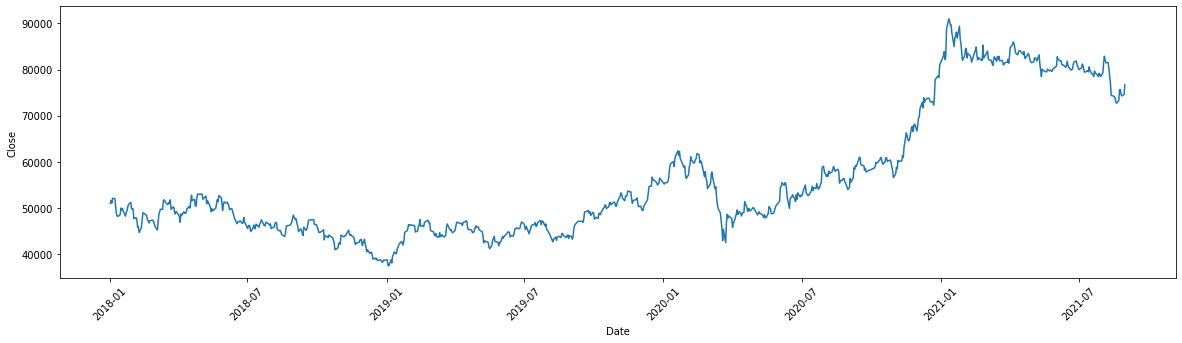

In [10]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=samsung, x='Date', y='Close')
plt.xticks(rotation=45)
plt.show()

### **④ Holidays**

In [11]:
holidays = pd.read_csv('holidays.csv')

holidays

,date,year,month,day,dd,explanation,weekend,holiday
0,2018-01-01,2018,1,1,Mon,새해,NaN,O
1,2018-01-02,2018,1,2,Tue,NaN,NaN,NaN
2,2018-01-03,2018,1,3,Wed,NaN,NaN,NaN
3,2018-01-04,2018,1,4,Thu,NaN,NaN,NaN
4,2018-01-05,2018,1,5,Fri,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1821,2022-12-27,2022,12,27,Tue,NaN,NaN,NaN
1822,2022-12-28,2022,12,28,Wed,NaN,NaN,NaN
1823,2022-12-29,2022,12,29,Thu,NaN,NaN,NaN
1824,2022-12-30,2022,12,30,Fri,NaN,NaN,NaN


In [12]:
print(type(holidays['date'][0]))
print(type(holidays['year'][0]))

<class 'str'>
<class 'numpy.int64'>


In [13]:
holidays['date'] = pd.to_datetime(holidays['date'])
print(type(holidays['date'][0]))
holidays

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


,date,year,month,day,dd,explanation,weekend,holiday
0,2018-01-01,2018,1,1,Mon,새해,NaN,O
1,2018-01-02,2018,1,2,Tue,NaN,NaN,NaN
2,2018-01-03,2018,1,3,Wed,NaN,NaN,NaN
3,2018-01-04,2018,1,4,Thu,NaN,NaN,NaN
4,2018-01-05,2018,1,5,Fri,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1821,2022-12-27,2022,12,27,Tue,NaN,NaN,NaN
1822,2022-12-28,2022,12,28,Wed,NaN,NaN,NaN
1823,2022-12-29,2022,12,29,Thu,NaN,NaN,NaN
1824,2022-12-30,2022,12,30,Fri,NaN,NaN,NaN


## **Preprocessing**

In [14]:
# 감성 어휘 사전 : negative / positive
# 뉴스 데이터 : df
# 주식 데이터 : samsung
# 공휴일 데이터 : holidays

### **① 뉴스 데이터 날짜 조정**
- <span style="color:blue">***전일 15시 ~ 금일 15시***</span>

In [15]:
# 업로드 시각 컬럼 추가
df['time'] = df['datetime'].str[-2:]

df.tail(1)

,st_n,st_cd,news,datetime,title,url,text,date,time
6181,삼성전자,005930,매일경제,2021090117,"""꿈의 격차 줄이자"" 삼성, 교육 사다리 놓는다",http://news.mk.co.kr/newsRead.php?no=845994&ye...,\n\n\n2015년 8월 광주 전남대에서 열린 드림클래스 여름 캠프를 방문한 이재...,2021-09-01,17


In [16]:
type(df['time'][0])

str

In [17]:
after_market = ['15', '16', '17', '18', '19', '20', '21', '22', '23']

for i in range(len(df['time'])):
    if df['time'][i] in after_market:
        df['date'][i] += datetime.timedelta(1)
    else:
        pass

df.tail(3)

<ipython-input-17-9a1624f19319>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'][i] += datetime.timedelta(1)


,st_n,st_cd,news,datetime,title,url,text,date,time
6179,삼성전자,005930,매일경제,2021090117,"제일기획, 하이브랩 투자…디지털 경쟁력 키운다",http://news.mk.co.kr/newsRead.php?no=846009&ye...,제일기획(대표 유정근)이 '하이브랩'과 손잡고 디지털 경쟁력 강화에 나선다. 제일기...,2021-09-02,17
6180,삼성전자,005930,매일경제,2021090117,"갤폴드3 플립3 무섭게 팔린다…삼성보다 더 신났다, 누구?",http://news.mk.co.kr/newsRead.php?no=845977&ye...,삼성전자의 폰더블폰 신모델(Z폴더3·플립3)이 초기 수요 흥행에 성공하면서 관련 부...,2021-09-02,17
6181,삼성전자,005930,매일경제,2021090117,"""꿈의 격차 줄이자"" 삼성, 교육 사다리 놓는다",http://news.mk.co.kr/newsRead.php?no=845994&ye...,\n\n\n2015년 8월 광주 전남대에서 열린 드림클래스 여름 캠프를 방문한 이재...,2021-09-02,17


In [18]:
# 텍스트 전처리
df['text'] = df['text'].str.replace('[\n|\t]', '')

<ipython-input-18-83a0f5301d1a>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('[\n|\t]', '')


### **② 주말 및 공휴일 제외**

In [19]:
market_closed = holidays[holidays['holiday']=="O"].reset_index(drop=True)

market_closed

,date,year,month,day,dd,explanation,weekend,holiday
0,2018-01-01,2018,1,1,Mon,새해,NaN,O
1,2018-01-06,2018,1,6,Sat,NaN,O,O
2,2018-01-07,2018,1,7,Sun,NaN,O,O
3,2018-01-13,2018,1,13,Sat,NaN,O,O
4,2018-01-14,2018,1,14,Sun,NaN,O,O
...,...,...,...,...,...,...,...,...
579,2022-12-17,2022,12,17,Sat,NaN,O,O
580,2022-12-18,2022,12,18,Sun,NaN,O,O
581,2022-12-24,2022,12,24,Sat,NaN,O,O
582,2022-12-25,2022,12,25,Sun,크리스마스,O,O


In [20]:
# 휴장일 List 생성
market_closed_list = list(market_closed['date'])

In [21]:
def stock_market_closed(df):
    for i in range(len(df['date'])):
        if df['date'][i] in market_closed_list:
            df['date'][i] += datetime.timedelta(1)
            stock_market_closed(df)
        else:
            pass

In [22]:
stock_market_closed(df)

df

<ipython-input-21-3042b38a67c9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'][i] += datetime.timedelta(1)


,st_n,st_cd,news,datetime,title,url,text,date,time
0,삼성전자,005930,매일경제,2020010104,의류건조기·식기세척기…新가전 열풍,http://news.mk.co.kr/newsRead.php?no=330&year=...,◆ 2020 경제기상도 / 업종별 전망 (가전) ◆\rLG전자가 올해 9월 독일 베...,2020-01-02,04
1,삼성전자,005930,매일경제,2020010104,美中리스크 완화에 D램 수요회복 `기대감`,http://news.mk.co.kr/newsRead.php?no=331&year=...,◆ 2020 경제기상도 / 업종별 전망 (반도체) ◆\r삼성전자는 신년에도 D램 낸...,2020-01-02,04
2,삼성전자,005930,매일경제,2020010104,무르익는 5G·폴더블폰…4년만에 반등 예감,http://news.mk.co.kr/newsRead.php?no=327&year=...,◆ 2020 경제기상도 / 업종별 전망 (스마트폰) ◆\r 올해는 5세대(5G) 이...,2020-01-02,04
3,삼성전자,005930,매일경제,2020010104,무르익는 5G·폴더블폰…4년만에 반등 예감,http://news.mk.co.kr/newsRead.php?no=327&year=...,◆ 2020 경제기상도 / 업종별 전망 (스마트폰) ◆\r 올해는 5세대(5G) 이...,2020-01-02,04
4,삼성전자,005930,매일경제,2020010113,삼성 반도체 공장 1분 정전…수십억 피해 예상,http://news.mk.co.kr/newsRead.php?no=1618&year...,[사진 제공: 연합뉴스] 삼성전자 경기 화성 사업장에 지난 31일 정전이 발생해 일...,2020-01-02,13
...,...,...,...,...,...,...,...,...,...
6177,삼성전자,005930,매일경제,2021090117,"""저가매수도 시기상조""…악소리 나는 배터리 게임 대장주를 어찌할꼬",http://news.mk.co.kr/newsRead.php?no=846038&ye...,최근 국내 증시에서 개별 종목 장세가 연출되는 가운데 악재가 발생할 때 해당 종목...,2021-09-02,17
6178,삼성전자,005930,매일경제,2021090117,"제일기획, 하이브랩 투자…디지털 경쟁력 키운다",http://news.mk.co.kr/newsRead.php?no=846009&ye...,제일기획(대표 유정근)이 '하이브랩'과 손잡고 디지털 경쟁력 강화에 나선다. 제일기...,2021-09-02,17
6179,삼성전자,005930,매일경제,2021090117,"제일기획, 하이브랩 투자…디지털 경쟁력 키운다",http://news.mk.co.kr/newsRead.php?no=846009&ye...,제일기획(대표 유정근)이 '하이브랩'과 손잡고 디지털 경쟁력 강화에 나선다. 제일기...,2021-09-02,17
6180,삼성전자,005930,매일경제,2021090117,"갤폴드3 플립3 무섭게 팔린다…삼성보다 더 신났다, 누구?",http://news.mk.co.kr/newsRead.php?no=845977&ye...,삼성전자의 폰더블폰 신모델(Z폴더3·플립3)이 초기 수요 흥행에 성공하면서 관련 부...,2021-09-02,17
